In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
gen_path = '/Users/neil/Downloads/NCI_genomics.xlsx'
path = '/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/Datasets/Carboplatin_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('/')[-1]
drug_name = dr.split('_')[0]
drug_name

'Carboplatin'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

#read the input genomics data 
genomics = pd.read_excel(gen_path)

In [6]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [7]:
#read the representative set of metabolites

with open('/Users/neil/Desktop/NCI Cell Lines/ModelRunNTimes/outputs/representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [8]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [9]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [10]:
X.shape

(52, 24023)

In [11]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [12]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [13]:
X.shape, y.shape

((52, 24023), (52,))

In [14]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    39
1    13
Name: count, dtype: int64

In [15]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [16]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.232135,1.028572,0.011856,0.047652,0.007258,0.058234,-0.047836,-0.015789,2.570610,0.072394,...,-0.960941,-1.023661,-0.432132,-1.223953,0.866732,-1.111073,-0.421944,0.325075,-0.736008,0.838635
1,1.937888,0.190776,-0.235872,-0.234950,0.007258,-0.183257,-0.047836,-0.015789,-0.905412,4.844086,...,-0.547528,-0.080363,-1.210185,0.089182,-1.052398,-0.958823,-1.137352,-2.254791,-1.718623,0.484500


In [17]:
X.shape, y.shape

((78, 24023), (78,))

In [18]:
y.value_counts()

1    39
0    39
Name: count, dtype: int64

In [19]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.232135,1.028572,0.011856,0.047652,0.007258,0.058234,-0.047836,-0.015789,2.570610,0.072394,...,-0.960941,-1.023661,-0.432132,-1.223953,0.866732,-1.111073,-0.421944,0.325075,-0.736008,0.838635
1,1.937888,0.190776,-0.235872,-0.234950,0.007258,-0.183257,-0.047836,-0.015789,-0.905412,4.844086,...,-0.547528,-0.080363,-1.210185,0.089182,-1.052398,-0.958823,-1.137352,-2.254791,-1.718623,0.484500


In [20]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [21]:
X_train.shape, X_test.shape

((62, 24023), (16, 24023))

In [22]:
y_train.value_counts(), y_test.value_counts()

(0    32
 1    30
 Name: count, dtype: int64,
 1    9
 0    7
 Name: count, dtype: int64)

In [23]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 637
Number of features selected during iteration 1: 612
Number of features selected during iteration 2: 635
Number of features selected during iteration 3: 614
Number of features selected during iteration 4: 608
Number of features selected during iteration 5: 639
Number of features selected during iteration 6: 623
Number of features selected during iteration 7: 625
Number of features selected during iteration 8: 626
Number of features selected during iteration 9: 634
Number of features selected during iteration 10: 629
Number of features selected during iteration 11: 635
Number of features selected during iteration 12: 626
Number of features selected during iteration 13: 619
Number of features selected during iteration 14: 631
Number of features selected during iteration 15: 632
Number of features selected during iteration 16: 613
Number of features selected during iteration 17: 633
Number of features selected during iteration 18: 620
Num

In [24]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(9, 617)

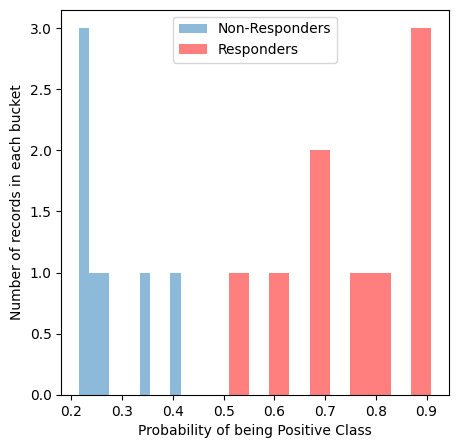

In [25]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [26]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [27]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.232135,1.028572,0.011856,0.047652,0.007258,0.058234,-0.047836,-0.015789,2.570610,0.072394,...,-0.432132,-1.223953,0.866732,-1.111073,-0.421944,0.325075,-0.736008,0.838635,0.598800,1.0
1,1.937888,0.190776,-0.235872,-0.234950,0.007258,-0.183257,-0.047836,-0.015789,-0.905412,4.844086,...,-1.210185,0.089182,-1.052398,-0.958823,-1.137352,-2.254791,-1.718623,0.484500,NaN,NaN
2,-0.570670,-0.976165,-0.338038,-0.235941,0.007258,-0.345623,-0.047836,-0.609313,-0.998666,0.072394,...,0.035429,-1.065174,-0.194790,-0.986928,-0.275221,-0.586859,-0.608030,-0.423158,NaN,NaN
3,2.248344,0.727101,-0.363286,-0.236587,-0.521599,0.058234,-0.047836,-0.417370,-0.664965,0.072394,...,-0.146547,-0.245666,0.330570,0.440540,-0.368663,-0.877145,0.686484,-0.980763,NaN,NaN
4,1.391531,-0.917843,0.011856,-0.234343,0.007258,0.058234,-0.047836,-0.323922,-0.920000,-0.083661,...,-1.304033,0.374422,-1.842681,1.440943,-2.094045,-0.706511,-1.184908,-0.281314,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.495221,-0.448757,-0.298605,-0.234559,-0.141265,-0.282284,-0.047836,-0.110574,-0.271111,2.544129,...,-0.542312,-0.093701,-0.296251,-0.572117,-0.206646,-0.361491,-0.859204,1.054115,NaN,NaN
74,-0.632101,-0.977118,-0.206351,-0.235514,-0.063914,-0.261644,-0.047836,-0.485894,-0.952988,0.072394,...,0.516478,-0.699213,0.162077,-0.865460,-0.302455,-0.062889,-0.201628,-0.421486,NaN,NaN
75,-0.903444,-0.539174,0.172738,-0.112176,-0.187048,0.058234,-0.047836,-0.015789,-0.794948,0.072394,...,0.920549,0.432961,0.659481,-0.766371,-0.576741,0.519645,0.665920,0.621238,0.800133,1.0
76,-0.949784,0.008723,0.020730,0.038836,-0.003460,0.058234,-0.047836,-0.015789,-0.814735,0.072394,...,-0.851605,0.108144,-0.409962,-1.217503,-0.788355,-1.233933,-0.178374,1.907123,NaN,NaN


In [28]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 24025)

In [29]:
df1_main.index.values #0 40 41 42

array([ 0, 42, 43])

In [30]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 634
Features selected during iteration 1: 610
Features selected during iteration 2: 615
Features selected during iteration 3: 620
Features selected during iteration 4: 631
Features selected during iteration 5: 624
Features selected during iteration 6: 615
Features selected during iteration 7: 632
Features selected during iteration 8: 615
Features selected during iteration 9: 624
Features selected during iteration 10: 623
Features selected during iteration 11: 627
Features selected during iteration 12: 617
Features selected during iteration 13: 626
Features selected during iteration 14: 640
Features selected during iteration 15: 622
Features selected during iteration 16: 621
Features selected during iteration 17: 610
Features selected during iteration 18: 610
Features selected during iteration 19: 610
Features selected during iteration 20: 629
Features selected during iteration 21: 603
Features selected during iteration 22: 626
Features selected dur

In [31]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 621.86


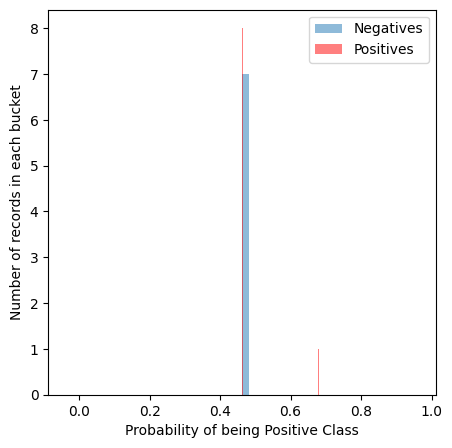

In [32]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [33]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [34]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.232135,1.028572,0.011856,0.047652,0.007258,0.058234,-0.047836,-0.015789,2.57061,0.072394,...,-0.432132,-1.223953,0.866732,-1.111073,-0.421944,0.325075,-0.736008,0.838635,0.681648,1.0
43,-0.866096,-0.980749,0.295248,-0.233884,-0.335010,0.058234,-0.047836,-0.015789,-0.77900,0.072394,...,2.348811,0.694747,1.521397,-0.402781,-0.406192,1.932936,1.346376,-0.415118,0.461723,1.0


In [35]:
df2_main.index.values #40 41 42

array([ 0, 43])

In [36]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 30
Features selected during iteration 1: 30
Features selected during iteration 2: 30
Features selected during iteration 3: 30
Features selected during iteration 4: 30
Features selected during iteration 5: 30
Features selected during iteration 6: 30
Features selected during iteration 7: 30
Features selected during iteration 8: 30
Features selected during iteration 9: 30
Features selected during iteration 10: 30
Features selected during iteration 11: 30
Features selected during iteration 12: 30
Features selected during iteration 13: 30
Features selected during iteration 14: 30
Features selected during iteration 15: 30
Features selected during iteration 16: 30
Features selected during iteration 17: 30
Features selected during iteration 18: 30
Features selected during iteration 19: 30
Features selected during iteration 20: 30
Features selected during iteration 21: 30
Features selected during iteration 22: 30
Features selected during iteration 23: 30
Fe

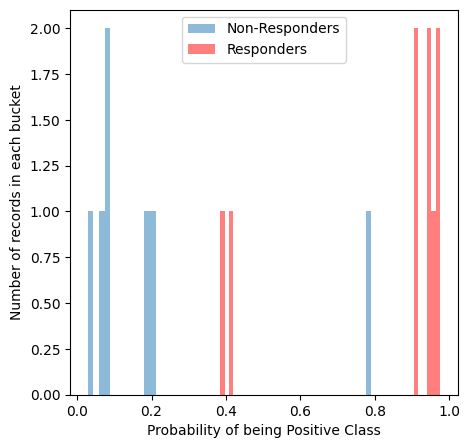

In [37]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [38]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.232135,1.028572,0.011856,0.047652,0.007258,0.058234,-0.047836,-0.015789,2.570610,0.072394,...,-0.432132,-1.223953,0.866732,-1.111073,-0.421944,0.325075,-0.736008,0.838635,0.384221,1.0
1,1.937888,0.190776,-0.235872,-0.234950,0.007258,-0.183257,-0.047836,-0.015789,-0.905412,4.844086,...,-1.210185,0.089182,-1.052398,-0.958823,-1.137352,-2.254791,-1.718623,0.484500,NaN,NaN
2,-0.570670,-0.976165,-0.338038,-0.235941,0.007258,-0.345623,-0.047836,-0.609313,-0.998666,0.072394,...,0.035429,-1.065174,-0.194790,-0.986928,-0.275221,-0.586859,-0.608030,-0.423158,NaN,NaN
3,2.248344,0.727101,-0.363286,-0.236587,-0.521599,0.058234,-0.047836,-0.417370,-0.664965,0.072394,...,-0.146547,-0.245666,0.330570,0.440540,-0.368663,-0.877145,0.686484,-0.980763,NaN,NaN
4,1.391531,-0.917843,0.011856,-0.234343,0.007258,0.058234,-0.047836,-0.323922,-0.920000,-0.083661,...,-1.304033,0.374422,-1.842681,1.440943,-2.094045,-0.706511,-1.184908,-0.281314,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.495221,-0.448757,-0.298605,-0.234559,-0.141265,-0.282284,-0.047836,-0.110574,-0.271111,2.544129,...,-0.542312,-0.093701,-0.296251,-0.572117,-0.206646,-0.361491,-0.859204,1.054115,NaN,NaN
74,-0.632101,-0.977118,-0.206351,-0.235514,-0.063914,-0.261644,-0.047836,-0.485894,-0.952988,0.072394,...,0.516478,-0.699213,0.162077,-0.865460,-0.302455,-0.062889,-0.201628,-0.421486,NaN,NaN
75,-0.903444,-0.539174,0.172738,-0.112176,-0.187048,0.058234,-0.047836,-0.015789,-0.794948,0.072394,...,0.920549,0.432961,0.659481,-0.766371,-0.576741,0.519645,0.665920,0.621238,0.940094,1.0
76,-0.949784,0.008723,0.020730,0.038836,-0.003460,0.058234,-0.047836,-0.015789,-0.814735,0.072394,...,-0.851605,0.108144,-0.409962,-1.217503,-0.788355,-1.233933,-0.178374,1.907123,NaN,NaN


In [39]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
43,-0.866096,-0.980749,0.295248,-0.233884,-0.33501,0.058234,-0.047836,-0.015789,-0.779,0.072394,...,2.348811,0.694747,1.521397,-0.402781,-0.406192,1.932936,1.346376,-0.415118,0.904689,1.0


In [40]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [41]:
cl = set(common_list)
cl

{0, 42, 43}

In [42]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.232135,1.028572,0.011856,0.047652,0.007258,0.058234,-0.047836,-0.015789,2.570610,0.072394,...,-0.432132,-1.223953,0.866732,-1.111073,-0.421944,0.325075,-0.736008,0.838635,0.5988,1.0
42,0.584748,-0.765439,0.007693,-0.229132,0.653855,-0.096125,-0.047836,6.403327,-0.056004,0.018707,...,-0.999006,0.152310,-1.585822,-0.004960,-2.206798,-1.075786,-1.853126,0.435572,0.5096,1.0
43,-0.866096,-0.980749,0.295248,-0.233884,-0.335010,0.058234,-0.047836,-0.015789,-0.779000,0.072394,...,2.348811,0.694747,1.521397,-0.402781,-0.406192,1.932936,1.346376,-0.415118,0.6792,1.0


In [43]:
with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/outputs/master_list_metabolomics.txt', 'w') as f:
    for i in cl:
        f.write(f'{i}\n')

In [44]:
l = []
l.extend(df1_total.index.values)
with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/outputs/total_metabolomics.txt', 'w') as f:
    for i in l:
        f.write(f'{i}\n')